# Modelo de Predição de Temperatura Interna

Organizacao - 1° notebook de modelo de predição de temperatura interna a cada 1 km em corrida autorregulada 

Algoritmos:
Lasso, Decision tree, Random forest, XGBoost, SVM

Apenas o algoritmo Lasso usou escalonamento 

Dados processados foram divididos em X e y. Depois divididos em 80% 20%. Nos 80% dados foi aplicado GroupKfold == 5. Os 20% restantes foram usados para a validação dos modelos

### Import library

In [2]:
#manipulação de dados
import pandas as pd
import numpy as np

#visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt

#modelagem e avaliação
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, LeaveOneGroupOut, GroupShuffleSplit, GroupKFold


### Import database

In [3]:
# X 
X = pd.read_csv('/home/usuario-leticia/Desktop/Samuel/leticiaag/tcore/data/processed-data/X-data1-1km.csv')

#y
y = pd.read_csv('/home/usuario-leticia/Desktop/Samuel/leticiaag/tcore/data/processed-data/y-data1-1km.csv')

#grupos
groups = pd.read_csv('/home/usuario-leticia/Desktop/Samuel/leticiaag/tcore/data/processed-data/groups-data1-1km.csv')

In [4]:
FEATURE_SETS = {
    'DS1': ['kilometer', 'wbgt', 'skin_temp', 'heart_rate', 'column_Male','age', 'vo2máx'],
    'DS2' : ['kilometer', 'wbgt', 'skin_temp', 'heart_rate', 'age', 'column_Male', 'vo2máx', 'speed'],
    'DS3' : ['kilometer', 'wbgt', 'skin_temp', 'heart_rate', 'age', 'column_Male', 'vo2máx', 'speed', 'umidade_absoluta', 'dry_temp', 'wet_temp', 'relative_humidity']
}

groups = groups['trial_number']

In [5]:
# divisao dos dados em treino e tese (Hold-out)
splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(X, y, groups=groups))
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
y_train = y_train.values.ravel() #transforma em array 1D
y_test = y_test.values.ravel() #transforma em array 1D
groups_train = groups.iloc[train_idx]

In [6]:
# definição de hiperparâmetros
OPTIMIZED_PARAMS = {
    'Lasso': {
        'DS1': {'alpha': 0.02868}, 
        'DS2': {'alpha': 0.02394},
        'DS3': {'alpha': 0.02631}
    },
    'SVR': {
        'DS1': {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale', 'epsilon': 0.1},
        'DS2': {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale', 'epsilon': 0.1},
        'DS3': {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale', 'epsilon': 0.1}
    },
    'DecisionTree': {
        'DS1': {'max_depth': 10, 'min_samples_leaf': 25, 'min_samples_split': 5},
        'DS2': {'max_depth': 10, 'min_samples_leaf': 25, 'min_samples_split': 5},
        'DS3': {'max_depth': 10, 'min_samples_leaf': 25, 'min_samples_split': 5}
    },
    'RandomForest': {
        'DS1': {'max_features': 0.8, 'max_samples': 0.8, 'min_samples_leaf': 10, 'min_samples_split': 30, 'n_estimators': 200},
        'DS2': {'max_features': 0.7, 'max_samples': 0.8, 'min_samples_leaf': 10, 'min_samples_split': 30, 'n_estimators': 200},
        'DS3': {'max_features': 0.7, 'max_samples': 0.8, 'min_samples_leaf': 10, 'min_samples_split': 30, 'n_estimators': 400}
    },
    'XGBoost': {
        'DS1': {'colsample_bytree': 0.5, 'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 700, 'reg_alpha': 0.1, 'reg_lambda': 6, 'subsample': 0.5},
        'DS2': {'colsample_bytree': 0.5, 'gamma': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500, 'reg_alpha': 0.1, 'reg_lambda': 8, 'subsample': 0.5},
        'DS3': {'colsample_bytree': 0.5, 'gamma': 1.0, 'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 700, 'reg_alpha': 0.1, 'reg_lambda': 8, 'subsample': 0.5}
    }
}

In [7]:
# execução da validação cruzada nos dados de treino
resultados_validacao = []
# Usando LeaveOneGroupOut (LOOCV) como solicitado.
# Ele fará uma iteração de validação para cada grupo (trial_number) único.
cv_splitter = LeaveOneGroupOut()
scoring = {
    'r2': 'r2',
    'rmse': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)
}

print("Iniciando a validação cruzada com Leave-One-Group-Out (LOOCV)")


scaled_models = ['Lasso', 'SVR']
tree_based_models = ['DecisionTree', 'RandomForest', 'XGBoost']

print('Iniciando Validação Cruzada')

for feature_set_name, feature_list in FEATURE_SETS.items():
    print(f'Validando com o conjunto de features: {feature_list}')
    X_train_subset = X_train[feature_list]

    #modelos que precisam de escalonamento
    for model_name in scaled_models:
        print(f'  Treinando modelo: {model_name} com escalonamento')
        params = OPTIMIZED_PARAMS[model_name][feature_set_name]

        if model_name == 'Lasso':
            model_instance = Lasso(random_state=42, max_iter=20000, **params)
        elif model_name == 'SVR':
            model_instance = SVR(**params)
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model_instance)
        ])

        scores = cross_validate(pipeline, X_train_subset, y_train, cv=cv_splitter, scoring=scoring, return_train_score=True, groups=groups_train)
        resultados_validacao.append({
            'model': model_name,
            'feature_set': feature_set_name,
            'scaled': True,
            'R2_train_cv': np.mean(scores['train_r2']),\
            'R2_valid_cv': np.mean(scores['test_r2']),\
            'RMSE_train_cv': -np.mean(scores['train_rmse']),\
            'RMSE_valid': -np.mean(scores['test_rmse'])\
\
        })


    #modelos baseados em árvore que não precisam de escalonamento
    for model_name in tree_based_models:
        print(f'  Treinando modelo: {model_name} sem escalonamento')
        params = OPTIMIZED_PARAMS[model_name][feature_set_name]
        if model_name == 'DecisionTree':
            model_instance = DecisionTreeRegressor(random_state=42, **params)
        elif model_name == 'RandomForest':
            model_instance = RandomForestRegressor(random_state=42, **params)
        elif model_name == 'XGBoost':
            model_instance = xgb.XGBRegressor(random_state=42, objective='reg:squarederror', **params)

        scores_unscaled = cross_validate(model_instance, X_train_subset, y_train, cv=cv_splitter, scoring=scoring,groups=groups_train, return_train_score=True)
        resultados_validacao.append({
            'model': model_name,
            'feature_set': feature_set_name,
            'scaled': False,
            'R2_train_cv': np.mean(scores['train_r2']),\
            'R2_valid_cv': np.mean(scores['test_r2']),\
            'RMSE_valid': -np.mean(scores['test_rmse']),\
            'RMSE_train_cv': -np.mean(scores['train_rmse'])\
            })\

print("Validação Cruzada Concluída")
results_validation_df = pd.DataFrame(resultados_validacao)

Iniciando a validação cruzada com Leave-One-Group-Out (LOOCV)
Iniciando Validação Cruzada
Validando com o conjunto de features: ['kilometer', 'wbgt', 'skin_temp', 'heart_rate', 'column_Male', 'age', 'vo2máx']
  Treinando modelo: Lasso com escalonamento
  Treinando modelo: SVR com escalonamento
  Treinando modelo: DecisionTree sem escalonamento
  Treinando modelo: RandomForest sem escalonamento
  Treinando modelo: XGBoost sem escalonamento
Validando com o conjunto de features: ['kilometer', 'wbgt', 'skin_temp', 'heart_rate', 'age', 'column_Male', 'vo2máx', 'speed']
  Treinando modelo: Lasso com escalonamento
  Treinando modelo: SVR com escalonamento
  Treinando modelo: DecisionTree sem escalonamento
  Treinando modelo: RandomForest sem escalonamento
  Treinando modelo: XGBoost sem escalonamento
Validando com o conjunto de features: ['kilometer', 'wbgt', 'skin_temp', 'heart_rate', 'age', 'column_Male', 'vo2máx', 'speed', 'umidade_absoluta', 'dry_temp', 'wet_temp', 'relative_humidity']
  

In [8]:
# selecao e avalicao final no conjunto de teste

best_experiment = results_validation_df.sort_values('RMSE_valid').iloc[-1]
best_model_name = best_experiment['model']
best_feature_set_name = best_experiment['feature_set']
best_params = OPTIMIZED_PARAMS[best_model_name][best_feature_set_name]
best_was_scaled = best_experiment['scaled']


print(f'Melhor modelo da validação cruzada : {best_experiment["model"]} ({best_experiment['feature_set']})')
print(f' - RMSE de validação (media da validação cruzada): {best_experiment["RMSE_valid"]:.4f}')


best_features = FEATURE_SETS[best_feature_set_name]
X_train_best = X_train[best_features]
X_test_best = X_test[best_features]



# instancia do modelos final
if best_model_name == 'Lasso':
    final_model = Lasso(random_state=42, max_iter=20000, **best_params)
elif best_model_name == 'SVR':
    final_model = SVR(**best_params)
elif best_model_name == 'DecisionTree':
    final_model = DecisionTreeRegressor(random_state=42, **best_params)
elif best_model_name == 'RandomForest':
    final_model = RandomForestRegressor(random_state=42, **best_params)
elif best_model_name == 'XGBoost':  
    final_model = xgb.XGBRegressor(random_state=42, objective='reg:squarederror', **best_params)


if best_was_scaled:
    final_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', final_model)
    ])
else:
    final_pipeline = Pipeline([
        ('model', final_model)
    ])


final_pipeline.fit(X_train_best, y_train)
y_test_pred = final_pipeline.predict(X_test_best)  
r2_final = r2_score(y_test, y_test_pred)
rmse_final = np.sqrt(mean_squared_error(y_test, y_test_pred))


print(f'Resultado final no conjunto de teste:(hold-out):')
print(f' - R²: {r2_final:.4f}')
print(f' - RMSE: {rmse_final:.4f}')

Melhor modelo da validação cruzada : RandomForest (DS2)
 - RMSE de validação (media da validação cruzada): 0.4347
Resultado final no conjunto de teste:(hold-out):
 - R²: 0.8582
 - RMSE: 0.3835


In [9]:
# Analisando as métricas de validação cruzada para todos os modelos
print("Análise das Métricas de Treino e Validação Cruzada para todos os modelos:")
print("Uma grande diferença entre as métricas 'train' e 'valid' indica overfitting.")
display(results_validation_df.round(4))

# Para uma análise mais profunda do overfitting, vamos criar gráficos

Análise das Métricas de Treino e Validação Cruzada para todos os modelos:
Uma grande diferença entre as métricas 'train' e 'valid' indica overfitting.


,model,feature_set,scaled,R2_train_cv,R2_valid_cv,RMSE_train_cv,RMSE_valid
0,Lasso,DS1,True,0.8103,0.7023,0.4090,0.3899
1,SVR,DS1,True,0.9228,0.6491,0.2609,0.4244
2,DecisionTree,DS1,False,0.9228,0.6491,0.2609,0.4244
3,RandomForest,DS1,False,0.9228,0.6491,0.2609,0.4244
4,XGBoost,DS1,False,0.9228,0.6491,0.2609,0.4244
5,Lasso,DS2,True,0.8137,0.6984,0.4053,0.3917
6,SVR,DS2,True,0.9302,0.6340,0.2482,0.4347
7,DecisionTree,DS2,False,0.9302,0.6340,0.2482,0.4347
8,RandomForest,DS2,False,0.9302,0.6340,0.2482,0.4347
9,XGBoost,DS2,False,0.9302,0.6340,0.2482,0.4347


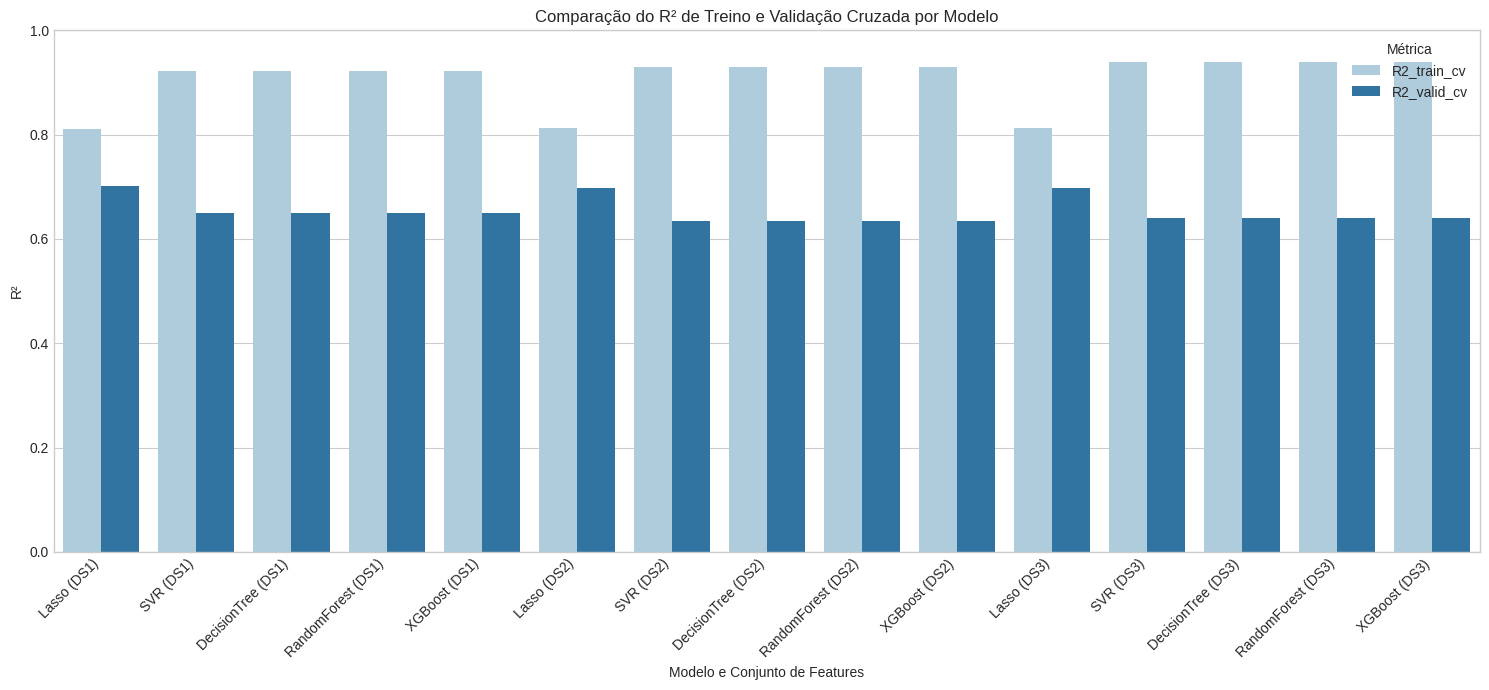

In [10]:
# Criando os gráficos de comparação
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração visual
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Paired")

# Preparando os dados para plotagem
results_plot = results_validation_df.melt(id_vars=['model', 'feature_set'],
                                         value_vars=['R2_train_cv', 'R2_valid_cv', 'RMSE_train_cv', 'RMSE_valid'],
                                         var_name='metric',
                                         value_name='value')

# Criando a feature_set_name para o eixo X
results_plot['experiment'] = results_plot['model'] + ' (' + results_plot['feature_set'] + ')'

# --- Gráfico de Comparação de RMSE ---
plt.figure(figsize=(15, 7))
rmse_data = results_plot[results_plot['metric'].isin(['RMSE_train_cv', 'RMSE_valid'])]
sns.barplot(data=rmse_data, x='experiment', y='value', hue='metric')
plt.title('Comparação do RMSE de Treino e Validação Cruzada por Modelo')
plt.ylabel('RMSE')
plt.xlabel('Modelo e Conjunto de Features')
plt.xticks(rotation=45, ha='right')
plt.ylim(bottom=0)
plt.legend(title='Métrica')
plt.tight_layout()
plt.savefig('rmse_train_vs_valid.png')
plt.close()

# --- Gráfico de Comparação de R² ---
plt.figure(figsize=(15, 7))
r2_data = results_plot[results_plot['metric'].isin(['R2_train_cv', 'R2_valid_cv'])]
sns.barplot(data=r2_data, x='experiment', y='value', hue='metric')
plt.title('Comparação do R² de Treino e Validação Cruzada por Modelo')
plt.ylabel('R²')
plt.xlabel('Modelo e Conjunto de Features')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.legend(title='Métrica')
plt.tight_layout()
plt.savefig('r2_train_vs_valid.png')
plt.show()

/tmp/ipykernel_11624/1739263106.py:59: UserWarning: Mismatched number of handles and labels: len(handles) = 30 len(labels) = 2
  fig.legend(handles=ax1.collections, labels=['Desempenho no Treino', 'Desempenho no Teste'], loc='lower center', ncol=2, fontsize=12, bbox_to_anchor=(0.5, -0.05))


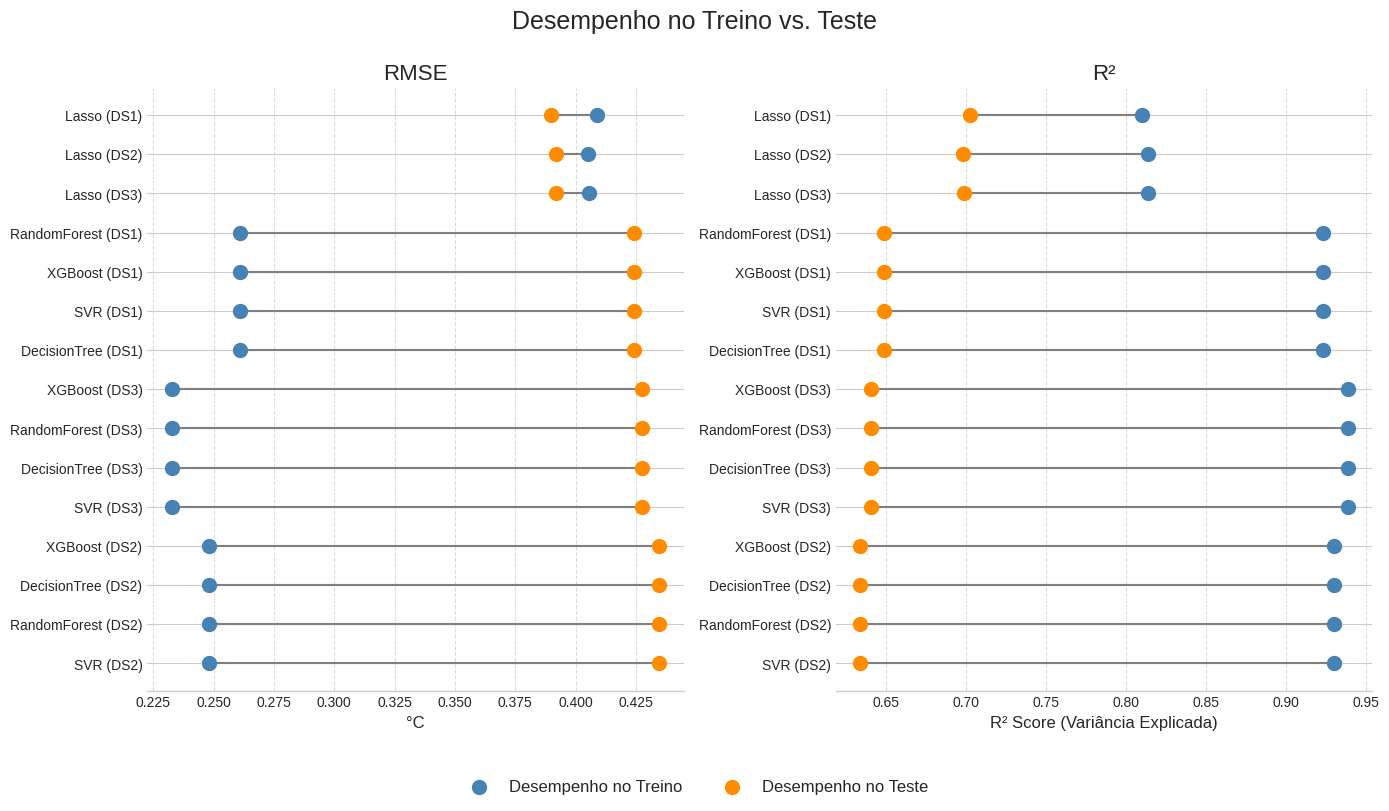

In [11]:
# Importando as bibliotecas necessárias para a visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Preparando os dados para plotagem
# Criando uma coluna única para o rótulo do experimento
results_validation_df['experiment_label'] = results_validation_df['model'] + ' (' + results_validation_df['feature_set'] + ')'

# Reordenando o DataFrame para uma melhor visualização (opcional, mas recomendado)
# Ordena por RMSE de validação
df_sorted = results_validation_df.sort_values(by='RMSE_valid', ascending=False)

# Criando a figura e os subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 8), gridspec_kw={'width_ratios': [1, 1]})

# --- Gráfico do RMSE ---
ax1 = axes[0]
for idx, row in df_sorted.iterrows():
    # Desenhando a linha
    ax1.plot([row['RMSE_valid'], row['RMSE_train_cv']], [row['experiment_label'], row['experiment_label']],
             color='gray', zorder=1)
    # Desenhando os pontos
    ax1.scatter(row['RMSE_train_cv'], row['experiment_label'], color='steelblue', label='Desempenho no Treino', s=100, zorder=2)
    ax1.scatter(row['RMSE_valid'], row['experiment_label'], color='darkorange', label='Desempenho no Teste', s=100, zorder=2)

# Configurações do gráfico RMSE
ax1.set_title('RMSE', fontsize=16)
ax1.set_xlabel('°C', fontsize=12)
ax1.set_ylabel('') # Deixa o rótulo do eixo Y vazio para centralizar na figura
ax1.grid(axis='x', linestyle='--', alpha=0.7)
ax1.tick_params(axis='y', length=0) # Remove os ticks do eixo Y
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)


# --- Gráfico do R² ---
ax2 = axes[1]
for idx, row in df_sorted.iterrows():
    # Desenhando a linha
    ax2.plot([row['R2_valid_cv'], row['R2_train_cv']], [row['experiment_label'], row['experiment_label']],
             color='gray', zorder=1)
    # Desenhando os pontos
    ax2.scatter(row['R2_train_cv'], row['experiment_label'], color='steelblue', label='Desempenho no Treino', s=100, zorder=2)
    ax2.scatter(row['R2_valid_cv'], row['experiment_label'], color='darkorange', label='Desempenho no Teste', s=100, zorder=2)

# Configurações do gráfico R²
ax2.set_title('R²', fontsize=16)
ax2.set_xlabel('R² Score (Variância Explicada)', fontsize=12)
ax2.set_ylabel('')
ax2.grid(axis='x', linestyle='--', alpha=0.7)
ax2.tick_params(axis='y', length=0)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

# Configurações da figura e legenda
fig.suptitle('Desempenho no Treino vs. Teste', fontsize=18, y=0.95)
fig.legend(handles=ax1.collections, labels=['Desempenho no Treino', 'Desempenho no Teste'], loc='lower center', ncol=2, fontsize=12, bbox_to_anchor=(0.5, -0.05))
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

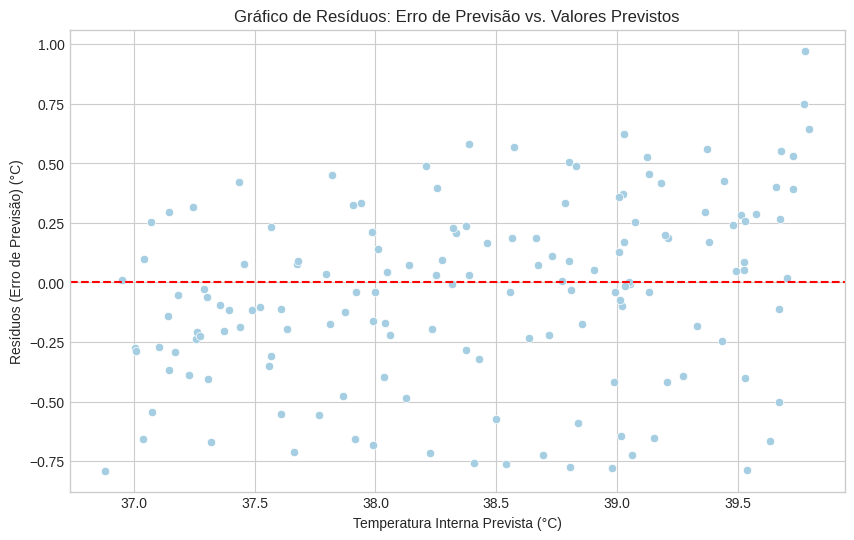

Análise dos 5 maiores erros de previsão:
     real   previsto   residuo
9   40.75  39.777023  0.972977
8   40.52  39.773130  0.746870
29  40.44  39.797414  0.642586
38  39.65  39.028484  0.621516
24  38.97  38.388446  0.581554


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculando os resíduos (erro de previsão) do modelo final no conjunto de teste
y_test_pred = final_pipeline.predict(X_test_best)
residuals = y_test - y_test_pred

# Criando o gráfico de resíduos
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_pred, y=residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Gráfico de Resíduos: Erro de Previsão vs. Valores Previstos')
plt.xlabel('Temperatura Interna Prevista (°C)')
plt.ylabel('Resíduos (Erro de Previsão) (°C)')
plt.grid(True)
plt.show()

# Salvando o gráfico para o notebook
plt.savefig('residuals_plot.png')
plt.close()

# Análise de outliers de erro: mostrando as 5 piores previsões
print("Análise dos 5 maiores erros de previsão:")
error_df = pd.DataFrame({'real': y_test, 'previsto': y_test_pred, 'residuo': residuals})
print(error_df.sort_values(by='residuo', ascending=False).head(5))


Importância das Features:
       feature  importance
0    kilometer    0.709714
3   heart_rate    0.185599
2    skin_temp    0.051414
6       vo2máx    0.016796
1         wbgt    0.012521
4          age    0.012156
7        speed    0.010185
5  column_Male    0.001614


/tmp/ipykernel_11624/2400713376.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importance_df, palette='viridis')


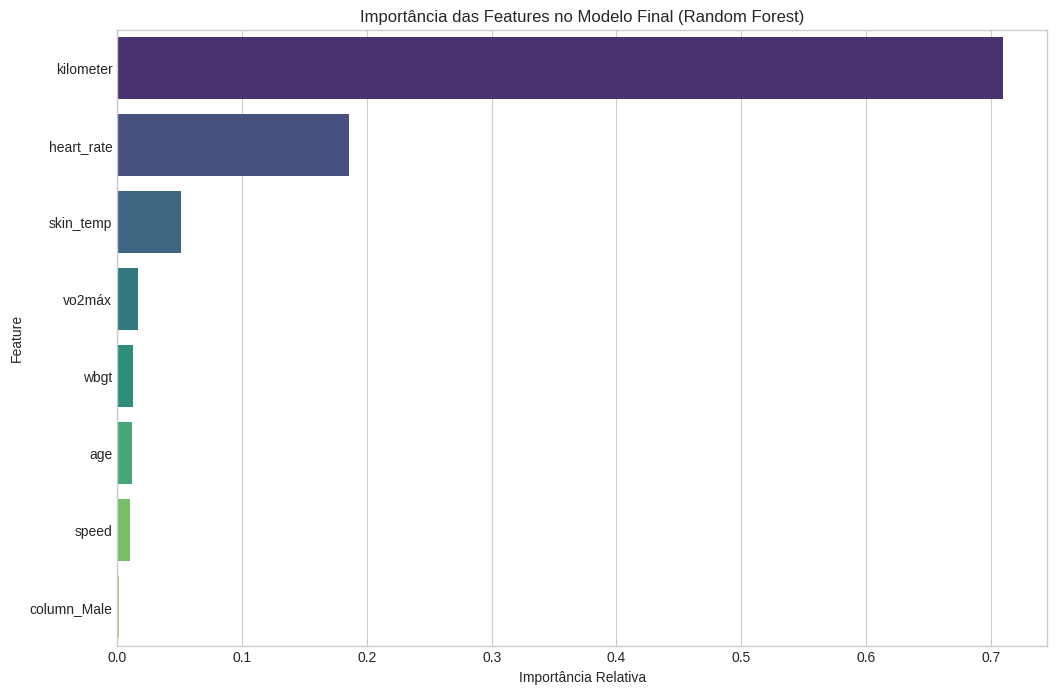


Gráfico de Resumo SHAP:


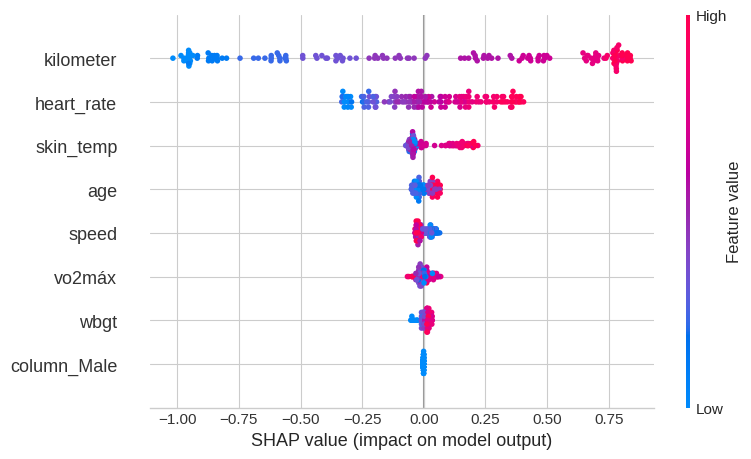

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Verificando se o melhor modelo é do tipo 'RandomForestRegressor' para extrair a importância das features
if isinstance(final_pipeline.named_steps['model'], RandomForestRegressor):
    # Obtendo o modelo da pipeline
    final_model = final_pipeline.named_steps['model']

    # Obtendo a importância das features e seus nomes
    feature_importances = final_model.feature_importances_
    feature_names = X_test_best.columns

    # Criando um DataFrame para facilitar a visualização e a ordenação
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importances
    }).sort_values(by='importance', ascending=False)

    print("\nImportância das Features:")
    print(importance_df)

    # Criando o gráfico de barras da importância das features
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=importance_df, palette='viridis')
    plt.title('Importância das Features no Modelo Final (Random Forest)')
    plt.xlabel('Importância Relativa')
    plt.ylabel('Feature')
    plt.show()

    plt.savefig('feature_importance_plot.png')
    plt.close()

    # --- Análise SHAP (SHapley Additive exPlanations) ---
    # Uma forma mais profunda de entender a importância e a contribuição de cada feature
    try:
        import shap

        # Criando o explainer SHAP
        explainer = shap.TreeExplainer(final_model)

        # Calculando os valores SHAP no conjunto de teste
        shap_values = explainer.shap_values(X_test_best)

        # Criando o gráfico de resumo SHAP
        print("\nGráfico de Resumo SHAP:")
        plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_values, X_test_best, show=False)
        plt.show()

        plt.savefig('shap_summary_plot.png')
        plt.close()

    except ImportError:
        print("A biblioteca SHAP não está instalada. Para executar esta análise, instale-a com 'pip install shap'.")

else:
    print("O modelo final não é baseado em árvores. A análise de importância de features não é diretamente aplicável.")

In [14]:
import pandas as pd
import numpy as np

# Exemplo de simulação de cenário.
# Vamos pegar um exemplo do seu conjunto de teste para simular uma mudança.
exemplo_dados = X_test_best.iloc[0:1].copy()

# Valor original da temperatura prevista
temp_original = final_pipeline.predict(exemplo_dados)[0]
print(f"Previsão original para o exemplo: {temp_original:.2f}°C")

# --- Cenário 1: Aumentando a temperatura ambiental (WBGT) ---
# Vamos simular um aumento de 2.0°C no WBGT
exemplo_dados_cenario1 = exemplo_dados.copy()
exemplo_dados_cenario1['wbgt'] = exemplo_dados_cenario1['wbgt'] + 2.0

# Previsão no cenário 1
temp_cenario1 = final_pipeline.predict(exemplo_dados_cenario1)[0]
print(f"Previsão no cenário com WBGT aumentado em 2°C: {temp_cenario1:.2f}°C")
print(f"Diferença na previsão: {temp_cenario1 - temp_original:.2f}°C")


# --- Cenário 2: Simulando um corredor mais rápido (aumento na velocidade) ---
# Vamos simular um aumento de 1 km/h na velocidade
if 'speed' in X_test_best.columns:
    exemplo_dados_cenario2 = exemplo_dados.copy()
    exemplo_dados_cenario2['speed'] = exemplo_dados_cenario2['speed'] + 1

    temp_cenario2 = final_pipeline.predict(exemplo_dados_cenario2)[0]
    print(f"\nPrevisão no cenário com velocidade aumentada em 1 km/h: {temp_cenario2:.2f}°C")
    print(f"Diferença na previsão: {temp_cenario2 - temp_original:.2f}°C")
else:
    print("\nO conjunto de features utilizado pelo modelo final (DS1) não contém a feature 'speed'.")

Previsão original para o exemplo: 37.44°C
Previsão no cenário com WBGT aumentado em 2°C: 37.44°C
Diferença na previsão: 0.00°C

Previsão no cenário com velocidade aumentada em 1 km/h: 37.42°C
Diferença na previsão: -0.01°C



Executando Análises SHAP Avançadas para Interpretabilidade do Modelo...

Gerando Gráfico de Dependência. Analisando o impacto do 'heart_rate'...


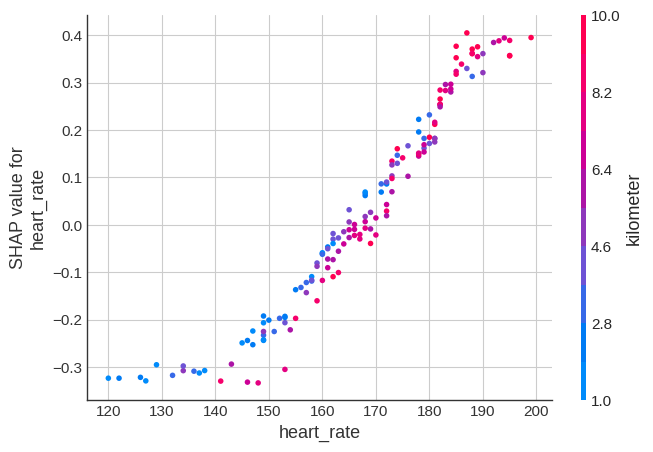

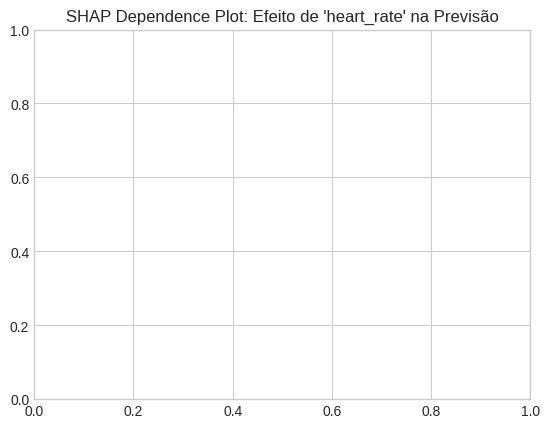


Gerando Gráfico de Força para a primeira previsão do conjunto de teste...


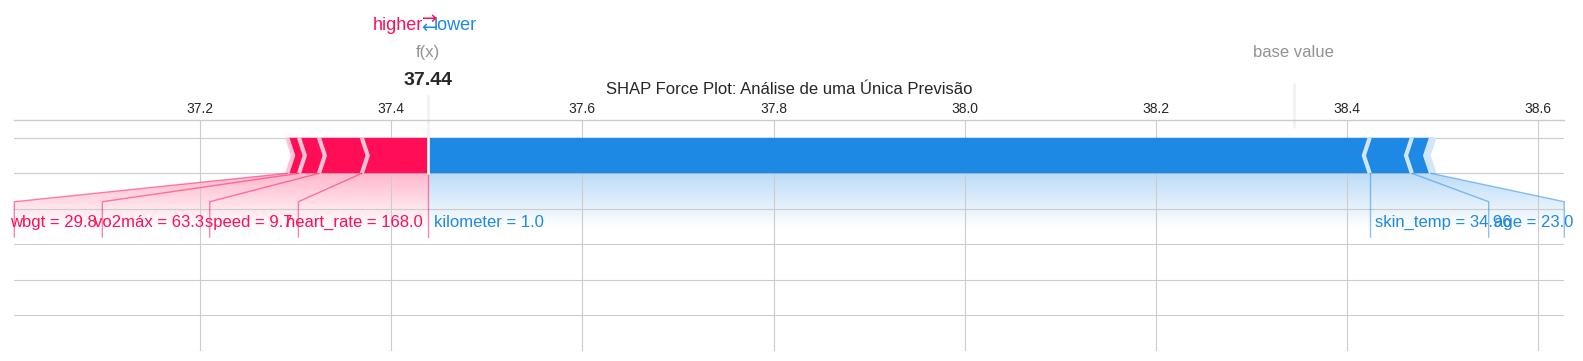


Gerando Gráfico de Interação. Analisando a interação entre 'speed' e 'heart_rate'...


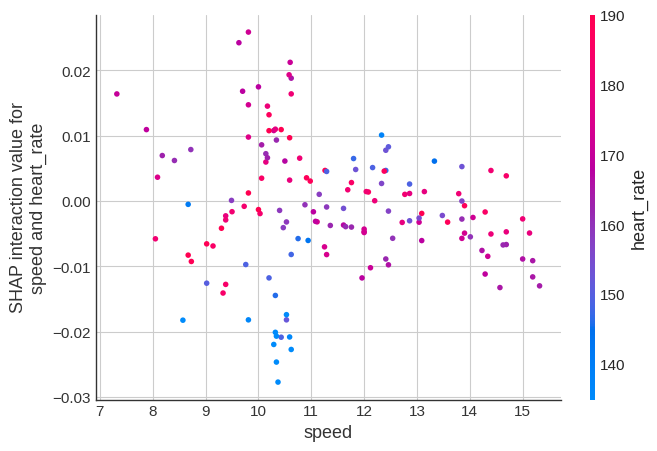

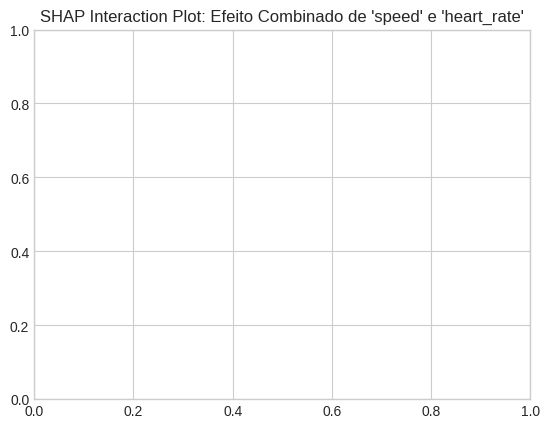

In [16]:
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
import numpy as np

print("\nExecutando Análises SHAP Avançadas para Interpretabilidade do Modelo...")

final_model = final_pipeline.named_steps['model']

if isinstance(final_model, (RandomForestRegressor, XGBRegressor, DecisionTreeRegressor)):
    try:
        # Calculando os valores SHAP
        explainer = shap.TreeExplainer(final_model)
        shap_values = explainer.shap_values(X_test_best)

        # --- Gráfico de Dependência (Dependence Plot) ---
        print("\nGerando Gráfico de Dependência. Analisando o impacto do 'heart_rate'...")
        # Escolha uma feature para o eixo X. Ex: 'heart_rate', 'wbgt', 'speed'
        feature_to_plot = 'heart_rate'

        # O SHAP automaticamente escolhe a feature de interação mais forte para a cor
        shap.dependence_plot(feature_to_plot, shap_values, X_test_best)
        plt.title(f"SHAP Dependence Plot: Efeito de '{feature_to_plot}' na Previsão")
        plt.show()

        # Salvar o gráfico
        plt.savefig(f'shap_dependence_plot_{feature_to_plot}.png')
        plt.close()

        # --- Gráfico de Força (Force Plot) ---
        print("\nGerando Gráfico de Força para a primeira previsão do conjunto de teste...")
        # O force plot explica uma única previsão. Você pode escolher qualquer índice
        # Por exemplo, para analisar a primeira previsão: shap_values[0]
        # Para um caso específico, você pode usar um índice de um erro de previsão grande
        shap_values_to_plot = explainer.expected_value[0] if isinstance(explainer.expected_value, np.ndarray) else explainer.expected_value

        shap.force_plot(
            shap_values_to_plot,
            shap_values[0,:],
            X_test_best.iloc[0,:],
            show=False,
            matplotlib=True
        )
        plt.title('SHAP Force Plot: Análise de uma Única Previsão')
        plt.show()

        # Salvar o gráfico
        plt.savefig('shap_force_plot_example.png')
        plt.close()

        # --- Gráfico de Interação (Interaction Plot) ---
        print("\nGerando Gráfico de Interação. Analisando a interação entre 'speed' e 'heart_rate'...")
        # Este gráfico mostra o efeito de interação entre duas features
        # O cálculo dos valores de interação pode ser demorado
        shap_interaction_values = explainer.shap_interaction_values(X_test_best)

        # Escolha as duas features para a interação
        interaction_feature1 = 'speed'
        interaction_feature2 = 'heart_rate'

        # Obtém os índices das features
        idx1 = list(X_test_best.columns).index(interaction_feature1)
        idx2 = list(X_test_best.columns).index(interaction_feature2)

        shap.dependence_plot(
            (interaction_feature1, interaction_feature2),
            shap_interaction_values,
            X_test_best,
            display_features=X_test_best
        )
        plt.title(f"SHAP Interaction Plot: Efeito Combinado de '{interaction_feature1}' e '{interaction_feature2}'")
        plt.show()

        plt.savefig(f'shap_interaction_plot_{interaction_feature1}_and_{interaction_feature2}.png')
        plt.close()

    except ImportError:
        print("A biblioteca SHAP não está instalada. Por favor, instale-a para rodar esta análise:")
        print("pip install shap")

    except Exception as e:
        print(f"Ocorreu um erro ao gerar o(s) gráfico(s) SHAP: {e}")

else:
    print("O modelo final não é baseado em árvores. As análises SHAP otimizadas (TreeExplainer) não são aplicáveis.")